# Supermarket Sales - Python EDA & Predictive Modeling
**Objective:** Explore 3 month supermarket transactions (Branch A, B, C) to uncover sales patterns, customer behaviour and product performance.
**Deliverables:** Clean dataset, EDA visuals, predictive models, and business insights.

**Key Questions:**
- Which branch and product lines drive revenue?
- When do we sell the most (day/hour)?
- How do customer types and payment methods differ?
- Can we predict total bill or payment method?

## 1. SETUP

In [1]:
import warnings, os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings .filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"]=(9,5)
RANDOM_STATE=42

In [2]:
# Paths
DATA_PATH = r"C:\Users\HP\Desktop\data analysis portfolio\Supermarket data analysis\supermarket_sales.csv"   # <- update if needed
EXPORT_DIR = "exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

In [86]:
import os

# Define your export folder
EXPORT_DIR = r"C:\Users\HP\Desktop\data analysis portfolio\Supermarket data analysis"

# Make sure the folder exists
os.makedirs(EXPORT_DIR, exist_ok=True)

EXPORT_DIR

'C:\\Users\\HP\\Desktop\\data analysis portfolio\\Supermarket data analysis'

## 2. LOAD DATA & QUICK PEEK

In [5]:
df=pd.read_csv(DATA_PATH)

In [7]:
display(df.head(3))

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4


In [9]:
print(df.shape)

(1000, 17)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [13]:
# Basic stats
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
Unit price,1000.0,55.672130,2.649463e+01,10.080000,32.875000,55.230000,77.935000,99.960000
Quantity,1000.0,5.510000,2.923431e+00,1.000000,3.000000,5.000000,8.000000,10.000000
Tax 5%,1000.0,15.379369,1.170883e+01,0.508500,5.924875,12.088000,22.445250,49.650000
Total,1000.0,322.966749,2.458853e+02,10.678500,124.422375,253.848000,471.350250,1042.650000
cogs,1000.0,307.587380,2.341765e+02,10.170000,118.497500,241.760000,448.905000,993.000000
gross margin percentage,1000.0,4.761905,6.131498e-14,4.761905,4.761905,4.761905,4.761905,4.761905
gross income,1000.0,15.379369,1.170883e+01,0.508500,5.924875,12.088000,22.445250,49.650000
Rating,1000.0,6.972700,1.718580e+00,4.000000,5.500000,7.000000,8.500000,10.000000


## 3. Cleanliness & Types

In [15]:
# Standardize Column Names (snake_case)
df.columns=(df.columns
            .str.strip()
            .str.lower()
            .str.replace(r"[\s/]+","_",regex=True))

In [17]:
df.rename(columns={"invoice_id":"invoice_id"},inplace=True)

In [19]:
# Covert Types
df["date"]=pd.to_datetime(df["date"], errors="coerce")
# Time can be HH:MM or HH:MM:SS
df["time"]=pd.to_datetime(df["time"], format="%H:%M", errors="coerce").dt.time.fillna(
    pd.to_datetime(df["time"], errors="coerce").dt.time
)

In [24]:
# duplicates & missings
dup_count=df.duplicated().sum()
na_count=df.isna().sum().sort_values(ascending=False)

dup_count, na_count

(0,
 invoice_id                 0
 total                      0
 gross_income               0
 gross_margin_percentage    0
 cogs                       0
 payment                    0
 time                       0
 date                       0
 tax_5%                     0
 branch                     0
 quantity                   0
 unit_price                 0
 product_line               0
 gender                     0
 customer_type              0
 city                       0
 rating                     0
 dtype: int64)

**Checks to comment on:**
- Duplicates removed?
    Yes
- Any nulls in critical columns (date, time, total, quantity)?
    Yes
- Currency/monetary columns look numeric (unit_price, tax, total, cogs, gross_income)?
    Yes

## 4. BUSINESS LOGICS SANITY CHECKS

In [21]:
# Recompute expected totals based on cogs and 5% tax
if {"cogs", "tax_5%", "total"}.issubset(df.columns):
    df["recalc_total"]=df["cogs"]+df["tax_5%"]
    # Evaluate tolerance due to float
    diff=np.abs(df["recalc_total"]-df["total"])
    print("Share of rows with exact total margin within 0.01:", (diff<=0.01).mean())

Share of rows with exact total margin within 0.01: 1.0


There are no inconsistencies between the provided totals in the dataset and the recomputed ones

In [23]:
# Check Gross Margin
if {"gross_income", "cogs", "gross_margin_percentage"}.issubset(df.columns):
    df["recalc_gm_pct"]=np.where(df["cogs"]>0,
                                 (df["gross_income"]/df["cogs"])*100,
                                 np.nan)
    print("GM% (mean, recalc vs. provided):", df["recalc_gm_pct"].mean(), df["gross_margin_percentage"].mean())

GM% (mean, recalc vs. provided): 5.0 4.761904762


In [25]:
# Row-level tolerance check
diff_2 = np.abs(df["recalc_gm_pct"] - df["gross_margin_percentage"])
print("Share of rows with GM% difference <= 0.01:", (diff <= 0.01).mean())
print("Number of mismatched rows:", (diff > 0.01).sum())

Share of rows with GM% difference <= 0.01: 1.0
Number of mismatched rows: 0


## FEATURE ENGINEERING

In [27]:
# Ensure date is in datetime format
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Date parts
df["year"]=df["date"].dt.year
df["month"]=df["date"].dt.month
df["date_only"]=df["date"].dt.date
df["weekday"]=df["date"].dt.day_name()

# Hour from time
df["hour"]=pd.to_datetime(df["time"].astype(str), errors='coerce').dt.hour

# Flags
df["is_weekend"]=df["weekday"].isin(["Saturday","Sunday"])

# Basket metrics
df["basket_size"]=df["total"]/df["quantity"]
df["net_sales"] = df["total"] - df["tax_5%"]

#Peak hour flag
df["is_peak_hour"]=df["hour"].between(17,20, inclusive="both")

In [29]:
df.head(3)

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5%,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,recalc_total,recalc_gm_pct,year,month,date_only,weekday,hour,is_weekend,basket_size,net_sales,is_peak_hour
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1,548.9715,5.0,2019,1,2019-01-05,Saturday,13,True,78.4245,522.83,False
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6,80.2200,5.0,2019,3,2019-03-08,Friday,10,False,16.0440,76.40,False
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4,340.5255,5.0,2019,3,2019-03-03,Sunday,13,True,48.6465,324.31,False


In [31]:
df.shape

(1000, 28)

## 6. HIGH-LEVEL KPIS

In [33]:
KPIS={
    "total_sales":df["total"].sum(),
    "total_gross_income":df["gross_income"].sum(),
    "avg_rating":df["rating"].mean(),
    "transactions":len(df),
    "avg_basket_size": df["basket_size"].mean()
}
pd.Series(KPIS).round(2)

total_sales           322966.75
total_gross_income     15379.37
avg_rating                 6.97
transactions            1000.00
avg_basket_size           58.46
dtype: float64

**Narrative:** Quick snapshot for executives (Sales, Gross Income, Avg Rating, Transactions).

## 7. EDA: TRENDS & DISTRIBUTION

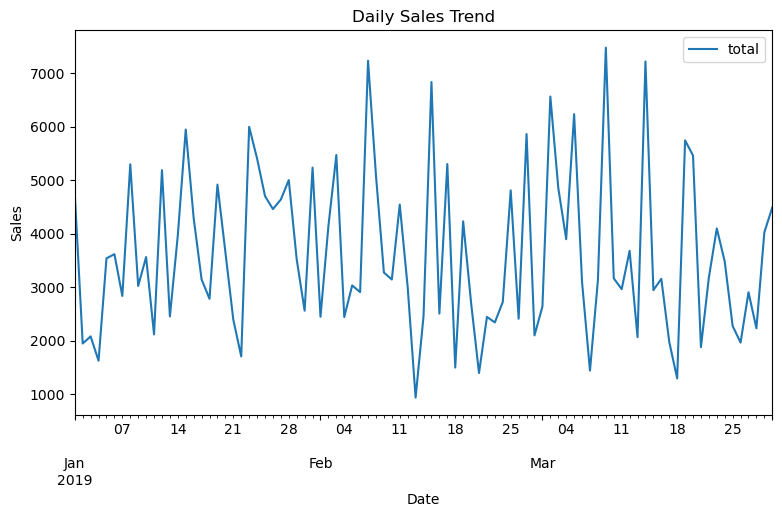

<Figure size 900x500 with 0 Axes>

In [72]:
# Daily Sales Trend
daily=df.groupby("date", as_index=False)["total"].sum()
ax=daily.plot(x="date", y="total", kind="line", title="Daily Sales Trend")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.show()
fig_path = os.path.join(EXPORT_DIR, "daily_sales_trend.png")
plt.savefig(fig_path, bbox_inches="tight")

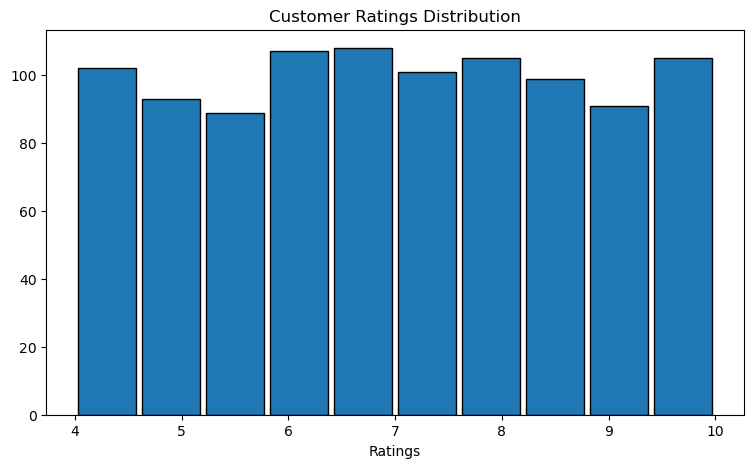

<Figure size 900x500 with 0 Axes>

In [74]:
# Rating Distribution
if "rating" in df.columns:
    plt.hist(df["rating"], bins=10, edgecolor="black", rwidth=0.9)
    plt.title("Customer Ratings Distribution")
    plt.xlabel("Ratings")
    plt.show()
    fig_path = os.path.join(EXPORT_DIR, "customer_ratingsdistribution.png")
plt.savefig(fig_path, bbox_inches="tight")

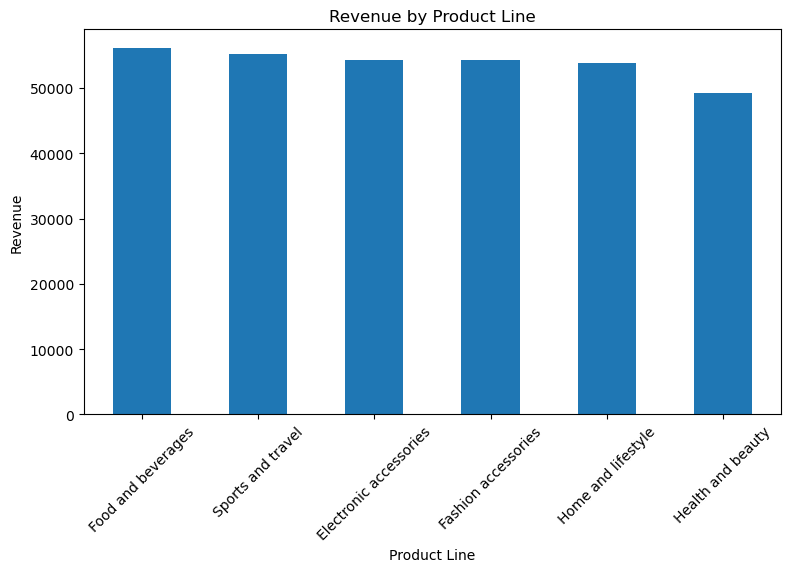

In [65]:
# Product Line Revenue
if "product_line" in df.columns:
    prod_rev=(df.groupby("product_line")["total"]
                .sum()
                .sort_values(ascending=False))
    ax=prod_rev.plot(x="product_line", y="total", kind="bar", title="Revenue by Product Line", rot=45)
    plt.xlabel("Product Line"); plt.ylabel("Revenue"); plt.show()

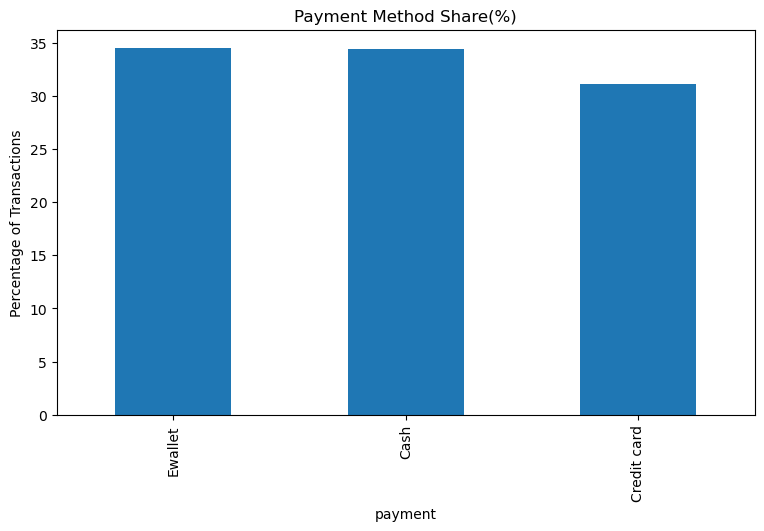

<Figure size 900x500 with 0 Axes>

In [76]:
# Payment Method Share
if "payment" in df.columns:
    pay= df["payment"].value_counts(normalize=True).mul(100).round(1)
    pay.plot(kind="bar", title="Payment Method Share(%)")
    plt.ylabel("Percentage of Transactions"); plt.show()
    fig_path = os.path.join(EXPORT_DIR, "percentage_of_transactions.png")
plt.savefig(fig_path, bbox_inches="tight")

- Sales appear to be trending slightly upward from January to March, with higher peaks in February and March compared to January.
- Food and Beverages dominates the reveue.
- Ewallet is used the most for payment.

## 8. EDA: CUSTOMER AND BRANCH INSIGHTS

In [78]:
# Revenue By Branch

if "branch" in df.columns:
    br=df.groupby("branch", as_index=False).agg(
        revenue=("total", "sum"),
        orders=("invoice_id", "nunique"),
        avg_ticket=("total", "mean"),
        avg_basket=("basket_size", "mean")
    ).sort_values("revenue", ascending=False)
    display(br)

,branch,revenue,orders,avg_ticket,avg_basket
2,C,110568.7065,328,337.099715,59.439476
0,A,106200.3705,340,312.354031,57.519896
1,B,106197.6720,332,319.872506,58.442241


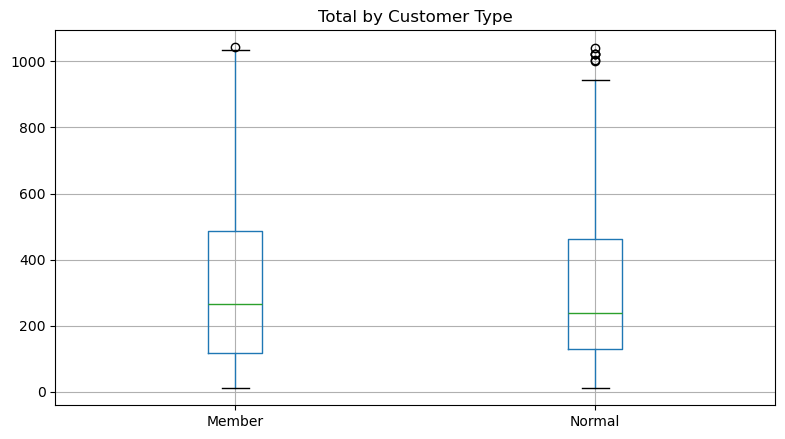

<Figure size 900x500 with 0 Axes>

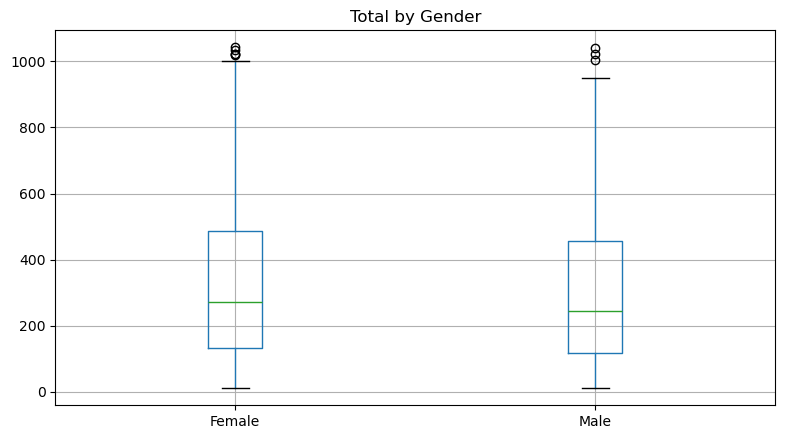

<Figure size 900x500 with 0 Axes>

In [94]:
# Revenue by Customer Type and Gender

if {"customer_type", "total"}.issubset(df.columns):
    df.boxplot(column="total", by="customer_type")
    plt.title("Total by Customer Type"); plt.suptitle(""); plt.xlabel(""); plt.show()

fig_path = os.path.join(EXPORT_DIR, "total_by_customer_type.png")
plt.savefig(fig_path, bbox_inches="tight")

if {"gender", "total"}.issubset(df.columns):
    df.boxplot(column="total", by="gender")
    plt.title("Total by Gender"); plt.suptitle(""); plt.xlabel(""); plt.show()

fig_path = os.path.join(EXPORT_DIR, "total_by_gender.png")
plt.savefig(fig_path, bbox_inches="tight")

- Branch C has highest revenue, average ticket, average basket while Branch A has the most number of orders.
- Members are more consistent spenders, while Normal customers show higher variability with a few very big spends.
- No major difference between Male and Female spend — both spend roughly the same on average.

## 9. EDA: WHEN DO WE SELL?

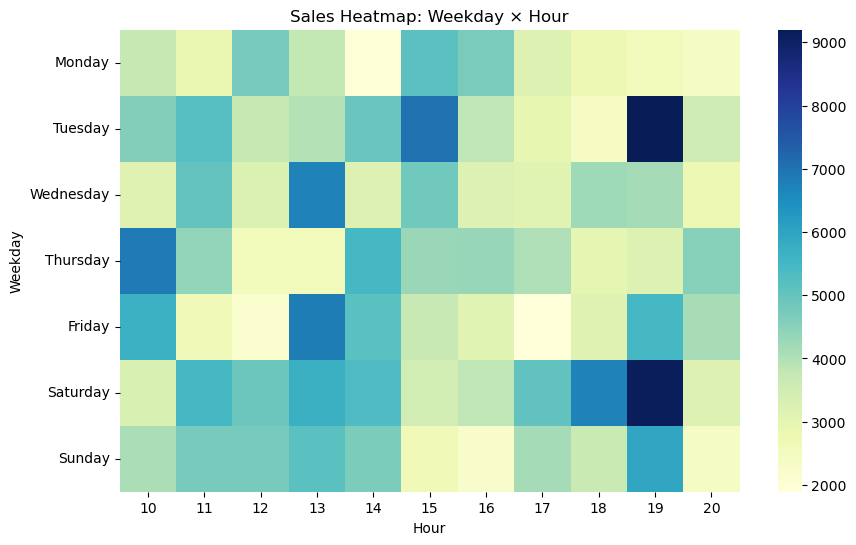

In [92]:
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(pivot_wh, cmap="YlGnBu", ax=ax)

plt.title("Sales Heatmap: Weekday × Hour")
plt.xlabel("Hour")
plt.ylabel("Weekday")

# Save before showing
save_path = os.path.join(EXPORT_DIR, "Sales_heatmap.png")
plt.savefig(save_path, bbox_inches="tight", dpi=300)

plt.show()

In [64]:
# Top Hours and Days

top_hours=df.groupby("hour")["total"].sum().sort_values(ascending=False)
top_days = df.groupby("weekday")["total"].sum().sort_values(ascending=False)
display(top_hours.head(5), top_days)

hour
19    39699.5130
13    34723.2270
10    31421.4810
15    31179.5085
14    30828.3990
Name: total, dtype: float64

weekday
Saturday     56120.8095
Tuesday      51482.2455
Thursday     45349.2480
Sunday       44457.8925
Friday       43926.3405
Wednesday    43731.1350
Monday       37899.0780
Name: total, dtype: float64

- Peak shopping windows are during lunchtime (12–15h) and evenings (18–20h).
- Weekends (Saturday & Sunday) and Tuesday show the highest traffic.

## 10.INSIGHTS AND RECOMMENDATIONS

## Key Insights
- **Branch performance:**
Branch C has highest revenue (110568.7065), average ticket (337.099715), average basket (59.439476) while Branch A has the most number of orders (340).
- **Product lines:**
Food & Beverages is the Top-Product line by revenue
- **Customer behavior:**
Both Members and Normal customers have a similar spending distribution.
The median spend looks slightly higher for Members.
- **Timing:**
Peak hours are 19:00, 13:00, 15:00, 14:00, 12:00 → meaning both lunchtime and evenings are the busiest.
Highest sales days are:
- Saturday (≈ 51,629)
- Tuesday (≈ 50,851)
- Sunday (≈ 49,352)
- Friday (≈ 44,975)
- **Payments:**
- Customers prefer to pay through ewallets

## Recommendations
- Increase staffing/promos during peak windows.
- Bundle offers in food and beverages; cross-sell complementary categories.
- Encourage E-wallet via small discounts during off-peak hours.

## 11. SAVE ARITFACTS

In [88]:
# Save cleaned dataset
clean_path = os.path.join(EXPORT_DIR, "supermarket_sales_clean.csv")
df.to_csv(clean_path, index=False)
clean_path

'C:\\Users\\HP\\Desktop\\data analysis portfolio\\Supermarket data analysis\\supermarket_sales_clean.csv'